In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
pd.options.display.max_rows = 999
from datetime import date, datetime, timedelta
from tqdm import tqdm

today = date.today()
tomorrow = date.today() + timedelta(days=2)

last_week = date.today() + timedelta(days=-5)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.optimizers import Adam
import os
from scipy.stats import linregress

pd.options.display.max_rows = 5000

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [2]:
#load data tables with stock lists

table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
dfsp500 = table[0]

table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_400_companies')
dfsp400 = table[0]

table=pd.read_html('https://en.wikipedia.org/wiki/NASDAQ-100')
dfnd100 = table[3]



#create necessary dataframes for stocks
#sp500tickers = pd.DataFrame(data = dfsp500['Symbol'].values, columns = ['ticker'])
#sp400tickers = pd.DataFrame(data = dfsp400['Ticker symbol'].values, columns = ['ticker'])
#dfnd100tickers = pd.DataFrame(data = dfnd100['Ticker'].values,columns = ['ticker'])
#stocks = sp500tickers.append(sp400tickers)
#stocks = stocks.append(dfnd100tickers).drop_duplicates().sort_values(by='ticker').reset_index(drop=True)
#stocklist = stocks[~stocks['ticker'].str.contains('\.|\$')]
#stocklist = pd.unique(stocklist['ticker'])

In [ ]:
#create train, test, validation sets
#stocklisttest = np.random.choice(stocklist,np.int(round(len(stocklist)*.2,0)),replace = False)
#stocklist = stocklist[~np.isin(stocklist,stocklisttest)]
#stocklistval = np.random.choice(stocklist,np.int(round(len(stocklist)*.25,0)),replace = False)
#stocklist = stocklist[~np.isin(stocklist,stocklistval)]
print('Test Sample Size',len(stocklisttest))
print('Train Sample Size',len(stocklist))
print('Val Sample Size',len(stocklistval))

In [ ]:
#creats data frame of training data used to create sequences

window = 80
sequence = 20
momentumlag = 90
X_train_i = []
y_train_i = []
X_test_i = []
y_test_i = []
historicallist = []
momentum90= []
momentum_price90 = []
minmax = pd.DataFrame(columns=['ticker','minopen','maxopen','minclose','maxclose','minlow','maxlow','minhigh','maxhigh','minvolume','maxvolume'])
alldata = pd.DataFrame(columns=['Date','ticker','Open','High','Low','Close','Volume','RSI','momentum','momentum_price'])
for stock in tqdm(stocklist):
    history = yf.Ticker(stock).history(start="2010-01-01").reset_index()
    history = history.dropna()
    if len(history) >= momentumlag+1:
        trainset = history.loc[:len(history)-sequence-1].copy()
        minmax = minmax.append({'ticker':stock,'minopen':min(trainset['Open']),'maxopen':max(trainset['Open']),'minclose':min(trainset['Close']),'maxclose':max(trainset['Close']),
                                'minlow':min(trainset['Low']),'maxlow':max(trainset['Low']),'minhigh':max(trainset['Low']),'maxhigh':min(trainset['High']),
                                'minvolume':min(trainset['Volume']),'maxvolume':max(trainset['Volume'])},ignore_index = True)
        trainset['PrevClose'] = trainset['Close'].shift(1)
        trainset['1DayChange'] = trainset['Close'] - trainset['PrevClose']
        trainset.loc[trainset['1DayChange'] > 0, 'Up'] = trainset['1DayChange'] 
        trainset.loc[trainset['1DayChange'] < 0, 'Up'] = 0
        trainset.loc[trainset['1DayChange'] < 0, 'Down'] = trainset['1DayChange']
        trainset.loc[trainset['1DayChange'] > 0, 'Down'] = 0
        trainset['RollUp'] = trainset['Up'].rolling(14,min_periods=0).mean()
        trainset['RollDown'] = trainset['Down'].rolling(14,min_periods=0).mean().abs()
        trainset['RSI'] = round(100 - (100/(1+(trainset['RollUp']/trainset['RollDown']))),4)
        trainset['RSI'] = np.nan_to_num(trainset['RSI'])
        momentum = []
        momentum_price = []
        for i in range(momentumlag-1,len(trainset)-1):
                rets = np.log(trainset['Close'].iloc[i-momentumlag+1:i+1])
                x = np.arange(len(rets))
                slope, intercept, r_value, p_value, std_err = linregress(x, rets)
                momentum.append(round(((1 + slope) ** 252) * (r_value ** 2),4))
                momentum_price.append(round(np.e ** (intercept + slope*len(x)),4))
        trainset['momentum'] = np.append(np.linspace(np.nan,np.nan,momentumlag),momentum)
        trainset['momentum_price'] = np.append(np.linspace(np.nan,np.nan,momentumlag),momentum_price)
        trainset['ticker'] = stock
        trainset = trainset[['Date','ticker','Open','High','Low','Close','Volume','RSI','momentum','momentum_price']].iloc[momentumlag:].copy()
        alldata = alldata.append(trainset)

In [ ]:
#save to data to csv
#alldata.to_csv(r'C:\Users\conno\Documents\Stocks\alldata.csv')

In [87]:
#read data in again
alldata = pd.read_csv(r'C:\Users\conno\Documents\Stocks\alldata.csv')

In [ ]:
#code for all historical train sequences

window = 20
sequence = 20
X_train = []
y_train = []

for ticker in tqdm(pd.unique(alldata['ticker'])):
    ticker = alldata[['Date','ticker','Open','High','Low','Close','Volume','RSI','momentum','momentum_price']][alldata['ticker']==ticker].reset_index(drop = True)
    if len(ticker) < window+sequence: continue
    for i in range(window-1, len(ticker)-sequence+1):
        ticker['Volume'] = ticker['Volume'].replace(0,1)
        prevclose = ticker['Close'].iloc[i-window+1]
        prevopen  = ticker['Open'].iloc[i-window+1]
        prevhigh  = ticker['High'].iloc[i-window+1]
        prevlow   = ticker['Low'].iloc[i-window+1]
        prevvol   = ticker['Volume'].iloc[i-window+1]
        prevmomentum = ticker['momentum'].iloc[i-window+1]
        prevmomentumprice = ticker['momentum_price'].iloc[i-window+1]
        seq = ticker['Close'].iloc[i:i+sequence]
        normseq = ticker['Close'].iloc[i:i+sequence] / prevclose
        normclose = ticker['Close'].iloc[i-window+1:i+1] / prevclose
        normopen = ticker['Open'].iloc[i-window+1:i+1] / prevopen
        normhigh = ticker['High'].iloc[i-window+1:i+1] / prevhigh
        normlow = ticker['Low'].iloc[i-window+1:i+1] / prevlow
        normvol = ticker[['Volume']].iloc[i-window+1:i+1] / prevvol
        normmomentum = ticker['momentum'].iloc[i-window+1:i+1]
        normmomentumprice = ticker['momentum_price'].iloc[i-window+1:i+1] / prevclose
        normrsi = ticker['RSI'].iloc[i-window+1:i+1] / 100
        normseq = normseq.replace(np.inf,np.nan)
        normclose= normclose.replace(np.inf,np.nan)
        normopen = normopen.replace(np.inf,np.nan)
        normhigh = normhigh.replace(np.inf,np.nan)
        normlow = normlow.replace(np.inf,np.nan)
        normvol = normvol.replace(np.inf,np.nan)
        normmomentum= normmomentum.replace(np.inf,np.nan)
        normmomentumprice = normmomentumprice.replace(np.inf,np.nan)
        normrsi = normrsi.replace(np.inf,np.nan)
        tickersym = ticker['ticker']
        X_append = np.hstack((np.reshape(normopen.values,(-1,1)),
                            np.reshape(normclose.values,(-1,1)),
                            np.reshape(normlow.values,(-1,1)),
                            np.reshape(normhigh.values,(-1,1)),
                            np.reshape(normvol.values,(-1,1)),
                            np.reshape(normmomentum.values,(-1,1)),
                            np.reshape(normmomentumprice.values,(-1,1)),
                            np.reshape(normrsi.values,(-1,1))))
        if pd.isnull(X_append).any() or pd.isnull(normseq).any(): continue
        else:
            X_train.append(X_append)
            y_train.append(normseq.values)

In [ ]:
#save historical train sequences
#np.save(r'C:\Users\conno\Documents\Stocks\X_train_model2020.npy',X_train)
#np.save(r'C:\Users\conno\Documents\Stocks\y_train_model2020.npy',y_train)

In [166]:
#code for all recent sequences for training
window = 20
sequence = 20

X_train = []
y_train = []
traintest = []
for ticker in tqdm(pd.unique(alldata['ticker'])):
    tickersym = ticker
    ticker = alldata[['Date','ticker','Open','High','Low','Close','Volume','RSI','momentum','momentum_price']][alldata['ticker']==ticker].reset_index(drop = True)
    prevclose = ticker['Close'].iloc[len(ticker)-window]
    prevopen  = ticker['Open'].iloc[len(ticker)-window]
    prevhigh  = ticker['High'].iloc[len(ticker)-window]
    prevlow   = ticker['Low'].iloc[len(ticker)-window]
    prevvol   = ticker['Volume'].iloc[len(ticker)-window]

    normclose = ticker['Close'].iloc[len(ticker)-window:] / prevclose
    normopen = ticker['Open'].iloc[len(ticker)-window:] / prevopen
    normhigh = ticker['High'].iloc[len(ticker)-window:] / prevhigh
    normlow = ticker['Low'].iloc[len(ticker)-window:] / prevlow
    normvol = ticker[['Volume']].iloc[len(ticker)-window:] / prevvol
    normmomentum = ticker['momentum'].iloc[len(ticker)-window:] 
    normmomentumprice = ticker['momentum_price'].iloc[len(ticker)-window:] / prevclose
    normrsi = ticker['RSI'].iloc[len(ticker)-window:] / 100
    X_append =  np.hstack((np.reshape(normopen.values,(-1,1)),
        np.reshape(normclose.values,(-1,1)),
        np.reshape(normlow.values,(-1,1)),
        np.reshape(normhigh.values,(-1,1)),
        np.reshape(normvol.values,(-1,1)),
        np.reshape(normmomentum.values,(-1,1)),
        np.reshape(normmomentumprice.values,(-1,1)),
        np.reshape(normrsi.values,(-1,1))))
    if pd.isnull(X_append).any() or len(X_append) != window: continue
    else:
        X_train.append(X_append)
        trainset = yf.Ticker(tickersym).history(start="2020-01-01").reset_index()
        trainset = trainset[trainset['Date']<="2020-11-11"]
        y_train.append(trainset['Close'].iloc[len(trainset)-sequence:].values / prevclose)

100%|████████████████████████████████████████████████████████████████████████████████| 543/543 [03:43<00:00,  2.43it/s]


In [135]:
#save data
np.save(r'C:\Users\conno\Documents\Stocks\X_train_model2020short.npy',X_train)
np.save(r'C:\Users\conno\Documents\Stocks\y_train_model2020short.npy',y_train)
#np.save(r'C:\Users\conno\Documents\Stocks\stocklist.npy',stocklist)
#np.save(r'C:\Users\conno\Documents\Stocks\stocklisttest.npy',stocklisttest)
#np.save(r'C:\Users\conno\Documents\Stocks\stocklistval.npy',stocklistval)

In [190]:
#creats data frame of testing data used to create sequences
sequence = 20
momentumlag = 90
X_test_i = []
y_test_i = []
historicallist = []
momentum= []
momentum_price = []
minmax = pd.DataFrame(columns=['ticker','minopen','maxopen','minclose','maxclose','minlow','maxlow','minhigh','maxhigh','minvolume','maxvolume'])
alldatatest = pd.DataFrame(columns=['Date','ticker','Open','High','Low','Close','Volume','RSI','momentum','momentum_price'])
for stock in tqdm(stocklisttest):
    history = yf.Ticker(stock).history(start="2010-01-01").reset_index()
    history = history[history['Date']<="2020-11-11"].copy()
    history = history.dropna()
    if len(history) >= momentumlag+1:
        testset = history.loc[:len(history)-sequence-1].copy()
        minmax = minmax.append({'ticker':stock,'minopen':min(testset['Open']),'maxopen':max(testset['Open']),'minclose':min(testset['Close']),'maxclose':max(testset['Close']),
                                'minlow':min(testset['Low']),'maxlow':max(testset['Low']),'minhigh':max(testset['Low']),'maxhigh':min(testset['High']),
                                'minvolume':min(testset['Volume']),'maxvolume':max(testset['Volume'])},ignore_index = True)
        testset['PrevClose'] = testset['Close'].shift(1)
        testset['1DayChange'] = testset['Close'] - testset['PrevClose']
        testset.loc[testset['1DayChange'] > 0, 'Up'] = testset['1DayChange'] 
        testset.loc[testset['1DayChange'] < 0, 'Up'] = 0
        testset.loc[testset['1DayChange'] < 0, 'Down'] = testset['1DayChange']
        testset.loc[testset['1DayChange'] > 0, 'Down'] = 0
        testset['RollUp'] = testset['Up'].rolling(14,min_periods=0).mean()
        testset['RollDown'] = testset['Down'].rolling(14,min_periods=0).mean().abs()
        testset['RSI'] = round(100 - (100/(1+(testset['RollUp']/testset['RollDown']))),4)
        testset['RSI'] = np.nan_to_num(testset['RSI'])
        momentum = []
        momentum_price = []
        for i in range(momentumlag-1,len(testset)-1):
                rets = np.log(testset['Close'].iloc[i-momentumlag+1:i+1])
                x = np.arange(len(rets))
                slope, intercept, r_value, p_value, std_err = linregress(x, rets)
                momentum.append(round(((1 + slope) ** 252) * (r_value ** 2),4))
                momentum_price.append(round(np.e ** (intercept + slope*len(x)),4))
        testset['momentum'] = np.append(np.linspace(np.nan,np.nan,momentumlag),momentum)
        testset['momentum_price'] = np.append(np.linspace(np.nan,np.nan,momentumlag),momentum_price)
        testset['ticker'] = stock
        testset = testset[['Date','ticker','Open','High','Low','Close','Volume','RSI','momentum','momentum_price']].iloc[momentumlag:].copy()
        alldatatest = alldatatest.append(testset)

 71%|████████████████████████████████████████████████████████▋                       | 129/182 [03:29<01:07,  1.28s/it]

- APY: No data found, symbol may be delisted


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [04:58<00:00,  1.64s/it]


In [192]:
alldatatest[['Volume','Open','High','Low','Close','RSI','momentum','momentum_price']] = alldatatest[['Volume','Open','High','Low','Close','RSI','momentum','momentum_price']].astype(np.float32)

In [222]:
X_test = []
y_test = []
window = 60
ticklist = []
for ticker in tqdm(pd.unique(alldatatest['ticker'])):
    tickersym = ticker
    ticker = alldatatest[['Date','ticker','Open','High','Low','Close','Volume','RSI','momentum','momentum_price']][alldatatest['ticker']==ticker].reset_index(drop = True)
    ticker['Volume'] = ticker['Volume'].replace(0,1)
    prevclose = ticker['Close'].iloc[len(ticker)-window]
    prevopen  = ticker['Open'].iloc[len(ticker)-window]
    prevhigh  = ticker['High'].iloc[len(ticker)-window]
    prevlow   = ticker['Low'].iloc[len(ticker)-window]
    prevvol   = ticker['Volume'].iloc[len(ticker)-window]

    normclose = ticker['Close'].iloc[len(ticker)-window:] / prevclose
    normopen = ticker['Open'].iloc[len(ticker)-window:] / prevopen
    normhigh = ticker['High'].iloc[len(ticker)-window:] / prevhigh
    normlow = ticker['Low'].iloc[len(ticker)-window:] / prevlow
    normvol = ticker[['Volume']].iloc[len(ticker)-window:] / prevvol
    normmomentum = ticker['momentum'].iloc[len(ticker)-window:] 
    normmomentumprice = ticker['momentum_price'].iloc[len(ticker)-window:] / prevclose
    normrsi = ticker['RSI'].iloc[len(ticker)-window:] / 100
    X_append =  np.hstack((np.reshape(normopen.values,(-1,1)),
        np.reshape(normclose.values,(-1,1)),
        np.reshape(normlow.values,(-1,1)),
        np.reshape(normhigh.values,(-1,1)),
        np.reshape(normvol.values,(-1,1)),
        np.reshape(normmomentum.values,(-1,1)),
        np.reshape(normmomentumprice.values,(-1,1)),
        np.reshape(normrsi.values,(-1,1))))
    if pd.isnull(X_append).any() or len(X_append) != window: continue
    else:
        X_test.append(X_append)
        testset = yf.Ticker(tickersym).history(start="2020-01-01").reset_index()
        testset = testset[testset['Date']<="2020-11-11"]
        y_test.append(testset['Close'].iloc[len(testset)-sequence:].values / prevclose)
        ticklist.append(tickersym)

100%|████████████████████████████████████████████████████████████████████████████████| 179/179 [00:53<00:00,  3.35it/s]


In [215]:
np.save(r'C:\Users\conno\Documents\Stocks\X_test_model8020.npy',X_test)
np.save(r'C:\Users\conno\Documents\Stocks\y_test_model8020.npy',y_test)

In [224]:
np.save(r'C:\Users\conno\Documents\Stocks\testticklist.npy',ticklist)

# Model Training

In [2]:
X_train = np.load(r'C:\Users\conno\Documents\Stocks\X_train_model6020short.npy', allow_pickle = True)
y_train = np.load(r'C:\Users\conno\Documents\Stocks\y_train_model6020short.npy', allow_pickle = True)

X_train=np.asarray(X_train).astype(np.float32)
y_train=np.asarray(y_train).astype(np.float32)

In [4]:
#train model

batch_size = 1
sequence = 20
checkpoint_filepath = r'C:\Users\conno\Documents\Stocks\checkpoints\Final\checkpoints'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='loss',mode='min',save_best_only=True)

n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

# The LSTM architecture
regressor = Sequential()
regressor.add(LSTM(units=450, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(LSTM(units=350, return_sequences=True))
regressor.add(LSTM(units=250, return_sequences=True))
regressor.add(LSTM(units=150, return_sequences=True))
regressor.add(LSTM(units=50))
regressor.add(Dense(units=sequence))
lr_schedule = ExponentialDecay(initial_learning_rate=.00001,decay_steps=10,decay_rate=0.9)
opt = Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999, epsilon=1e-08, amsgrad=False)

regressor.load_weights(r'C:\Users\conno\Documents\Stocks\checkpoints\Final\checkpoints')
# Compiling the RNN
regressor.compile(optimizer=opt, loss='mean_squared_error')
# Fitting to the training set
history = regressor.fit(X_train, y_train, epochs=15000, batch_size= batch_size, shuffle=True, callbacks=[model_checkpoint_callback])

Epoch 1/15000
541/541 [==============================] - 10s 19ms/step - loss: 6.0380e-09
Epoch 2/15000
541/541 [==============================] - 10s 19ms/step - loss: 6.0380e-09
Epoch 3/15000
541/541 [==============================] - 10s 19ms/step - loss: 6.0380e-09
Epoch 4/15000
122/541 [=====>........................] - ETA: 8s - loss: 5.7805e-09

KeyboardInterrupt: 

# Model Testing

In [230]:
Results = pd.DataFrame({'Sequence':[],'Type':[],'RMSE':[],'MAE':[]})
lengths = [20,40,60,80]
seqtypes = ['Short','Long']
cast = 20
for length in lengths:
    for seqtype in seqtypes:
        path = r'C:\Users\conno\Documents\Stocks\checkpoints'
        checkpath = os.path.join(path,str(length)+str(cast)+seqtype,"checkpoints")

        X_path = r'C:\Users\conno\Documents\Stocks\X_test_model' + str(length)+str(cast)+".npy"
        y_path = r'C:\Users\conno\Documents\Stocks\y_test_model' + str(length)+str(cast)+".npy"
        X_test = np.load(X_path,allow_pickle = True)
        y_test = np.load(y_path,allow_pickle = True)
        X_test=np.asarray(X_test).astype(np.float32)
        y_test=np.asarray(y_test).astype(np.float32)

        regressor = Sequential()
        regressor.add(LSTM(units=450, return_sequences=True, input_shape=(length, 8)))
        regressor.add(LSTM(units=350, return_sequences=True))
        regressor.add(LSTM(units=250, return_sequences=True))
        regressor.add(LSTM(units=150, return_sequences=True))
        regressor.add(LSTM(units=50))
        regressor.add(Dense(units=cast))

        regressor.load_weights(checkpath)
        preds = regressor.predict(X_test)
        predictions = pd.DataFrame(preds,columns = ['Pred1','Pred2','Pred3','Pred4','Pred5','Pred6','Pred7','Pred8','Pred9','Pred10','Pred11','Pred12','Pred13','Pred14','Pred15','Pred16','Pred17','Pred18','Pred19','Pred20'])
        Truth = pd.DataFrame(y_test,columns = ['Truth1','Truth2','Truth3','Truth4','Truth5','Truth6','Truth7','Truth8','Truth9','Truth10','Truth11','Truth12','Truth13','Truth14','Truth15','Truth16','Truth17','Truth18','Truth19','Truth20'])
        pd.set_option('display.float_format', lambda x: '%.3f' % x)
        TwentyTwentyShort = predictions.join(Truth, how='left')

        MSE = mean_squared_error(predictions['Pred20'],Truth['Truth20'],squared = False)
        MAE = mean_absolute_error(predictions['Pred20'],Truth['Truth20'])
        df = pd.DataFrame({'Sequence':[length],'Type':[seqtype],'RMSE':[MSE],'MAE':[MAE]})
        Results= Results.append(df)

In [231]:
Results

Sequence   Type  RMSE   MAE
0    20.000  Short 0.118 0.086
0    20.000   Long 0.125 0.096
0    40.000  Short 0.114 0.081
0    40.000   Long 0.135 0.100
0    60.000  Short 0.113 0.081
0    60.000   Long 0.135 0.102
0    80.000  Short 0.117 0.088
0    80.000   Long 0.136 0.103

In [ ]:
#testing for final model

In [4]:
testticklist = np.load(r'C:\Users\conno\Documents\Stocks\testticklist.npy')

In [5]:
sectorlist = []
for tick in tqdm(testticklist):
    try:
        info = yf.Ticker(tick).info
        sector = info['sector']
        sectorlist.append(sector)
    except:
        sectorlist.append('')
    

100%|████████████████████████████████████████████████████████████████████████████████| 178/178 [07:32<00:00,  2.54s/it]


In [8]:
len(testticklist)

178

0.116079174
0.08746114


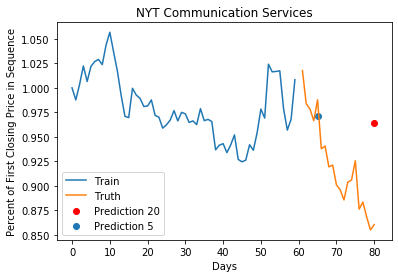

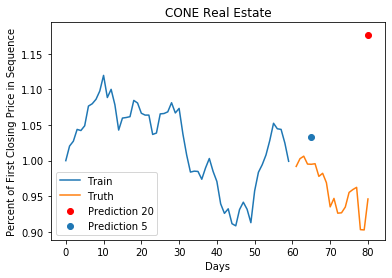

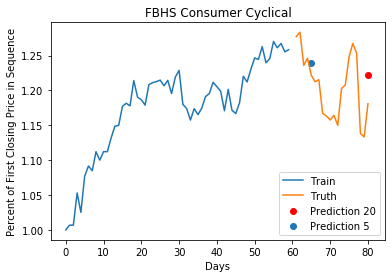

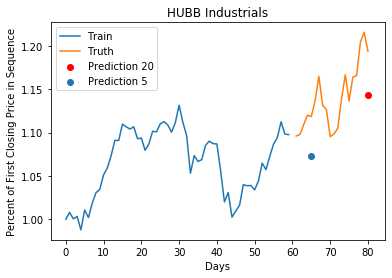

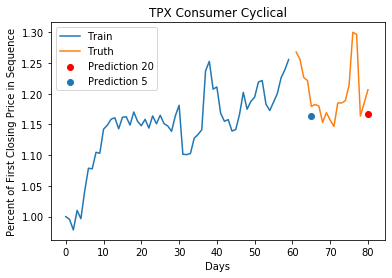

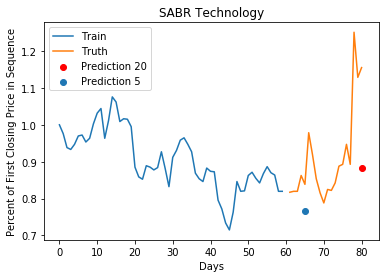

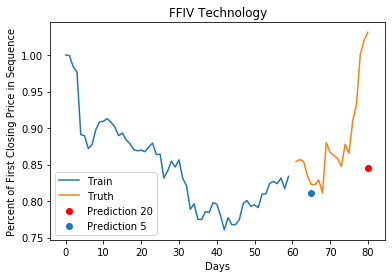

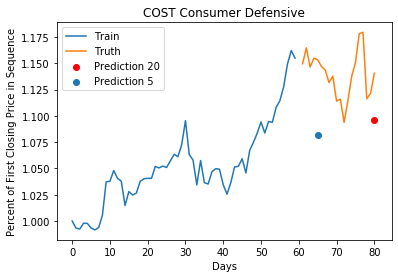

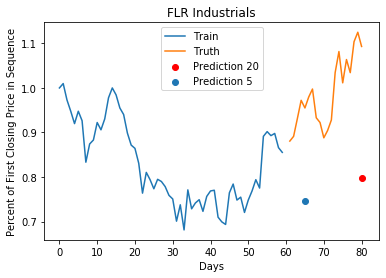

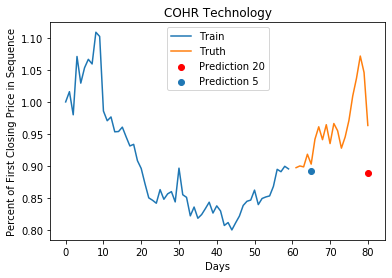

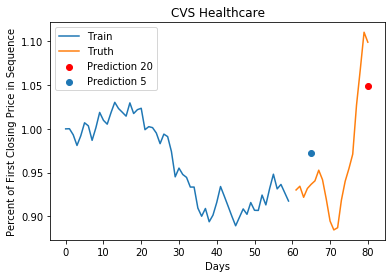

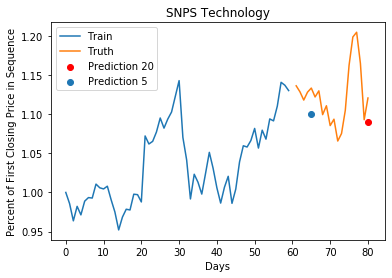

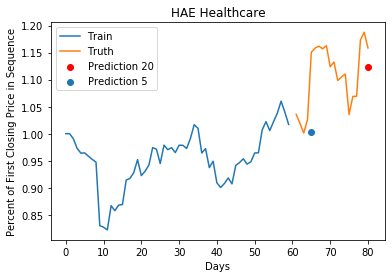

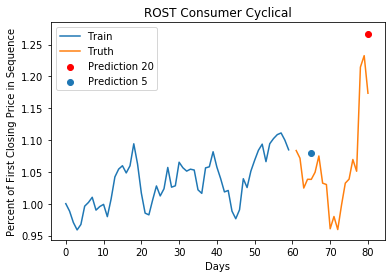

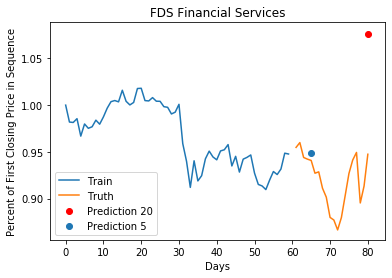

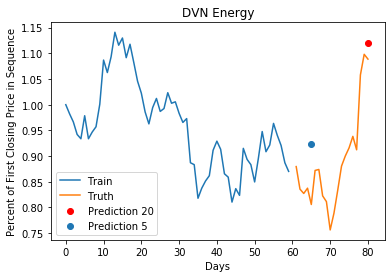

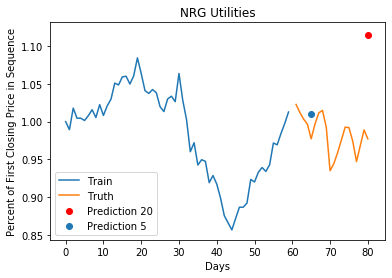

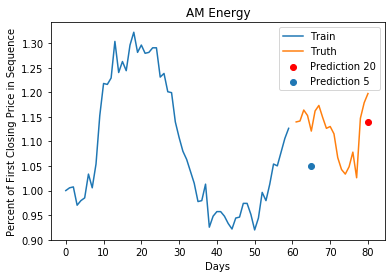

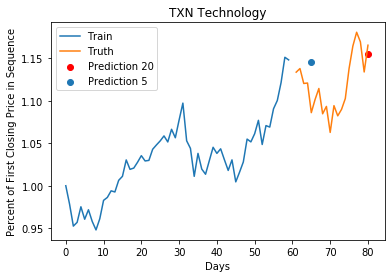

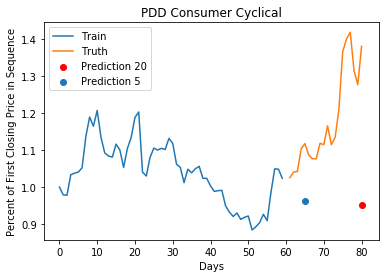

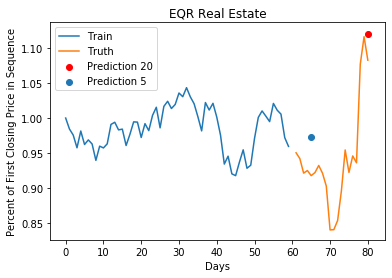

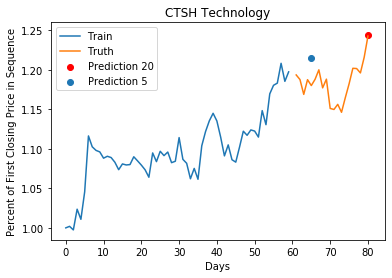

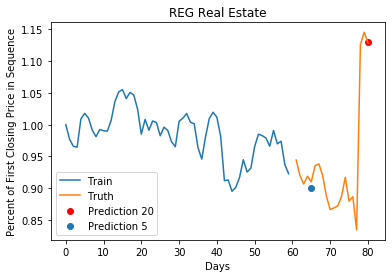

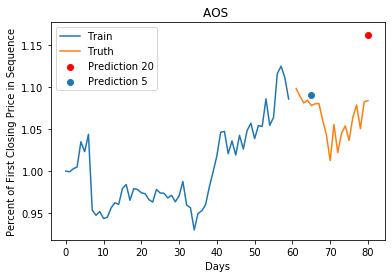

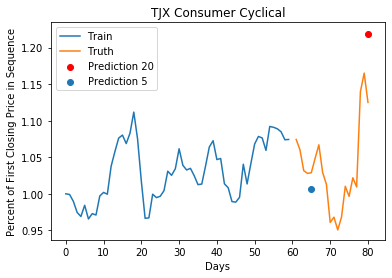

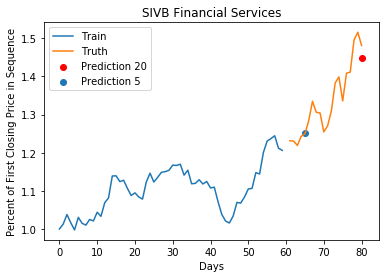

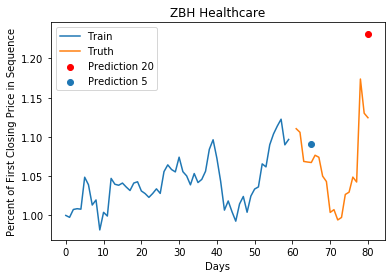

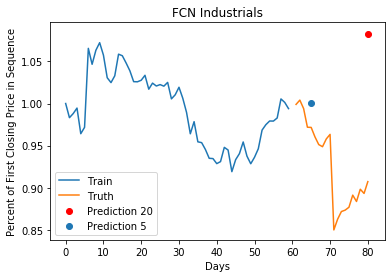

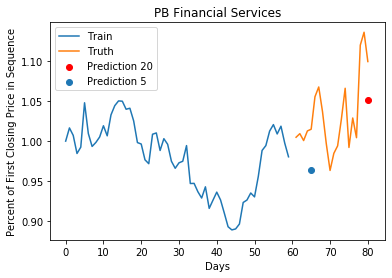

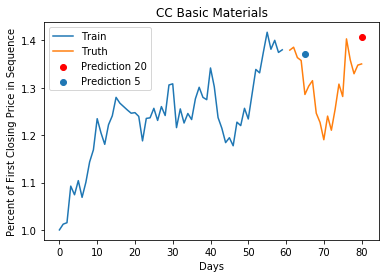

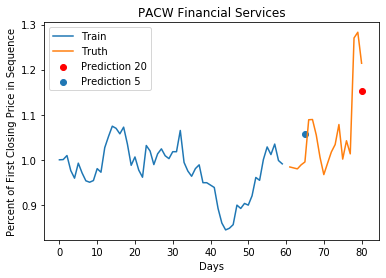

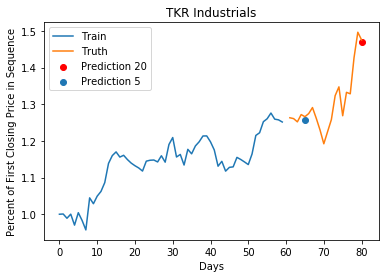

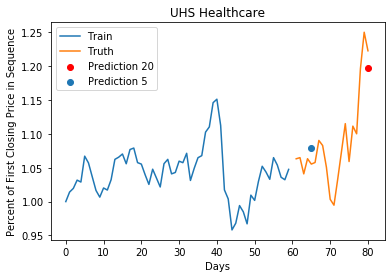

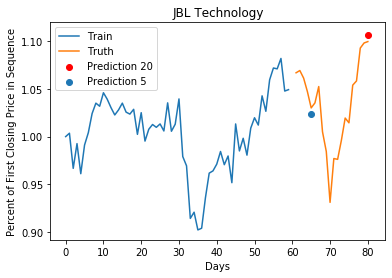

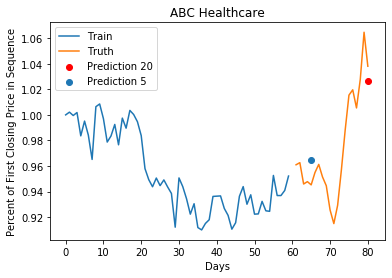

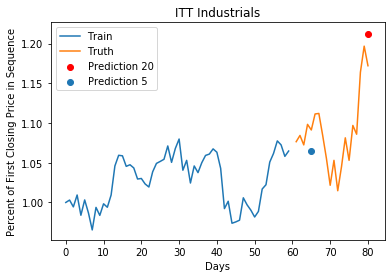

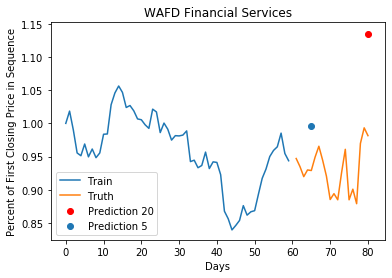

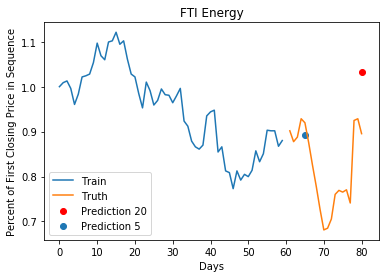

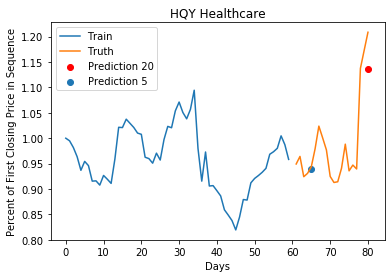

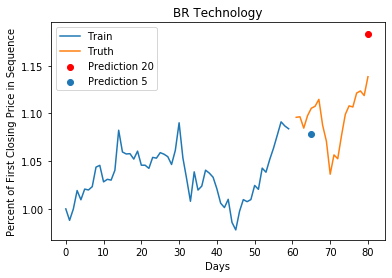

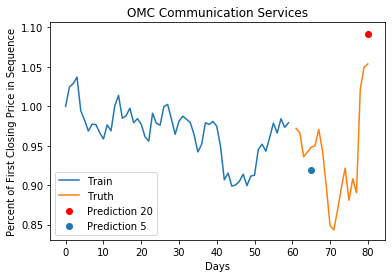

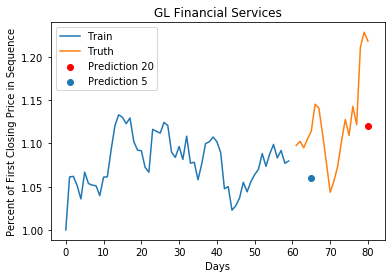

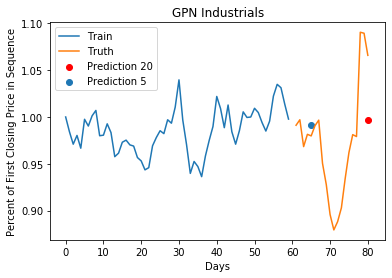

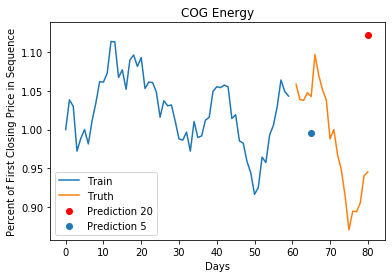

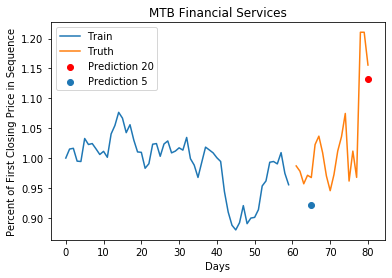

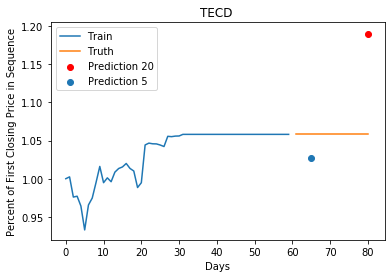

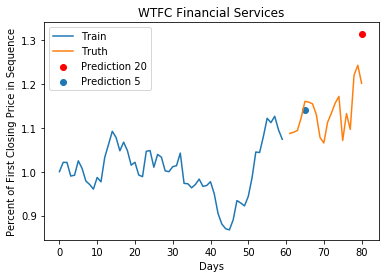

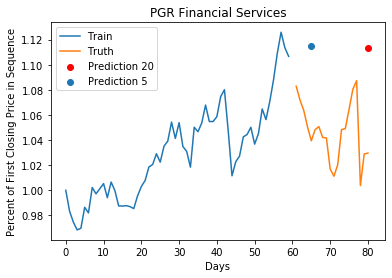

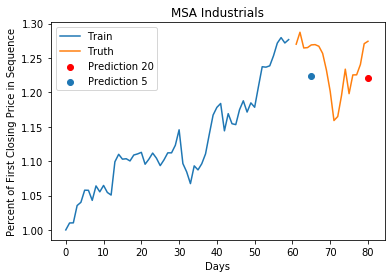

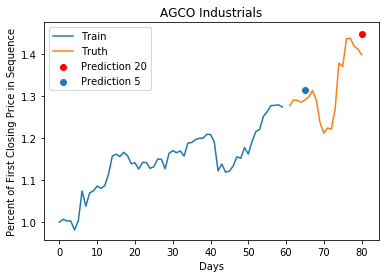

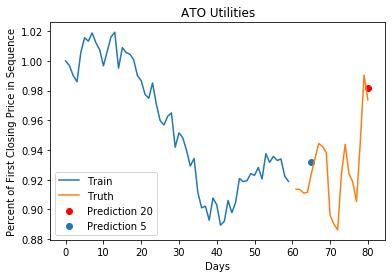

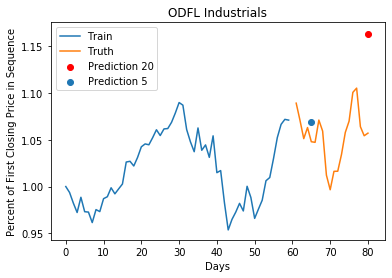

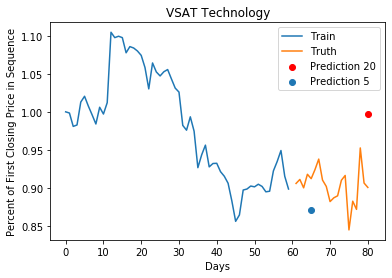

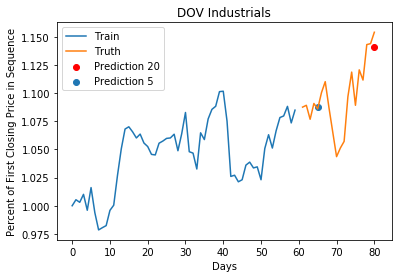

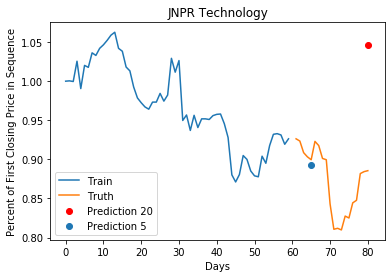

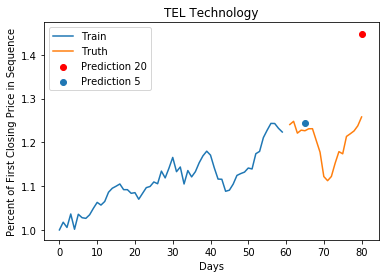

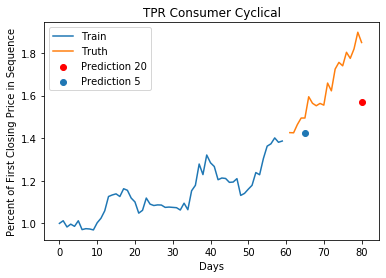

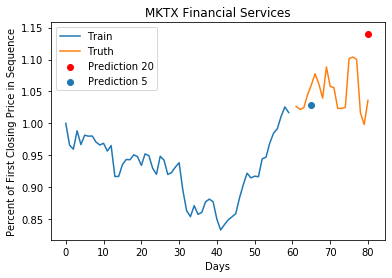

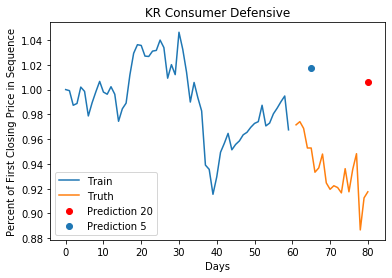

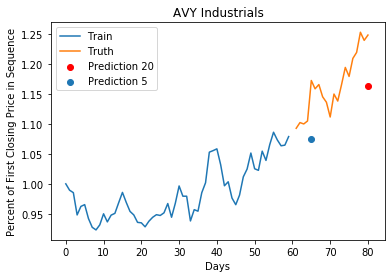

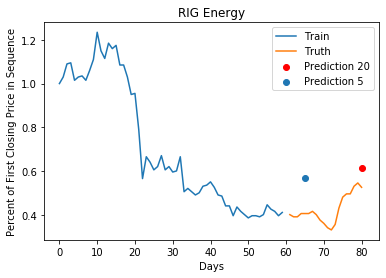

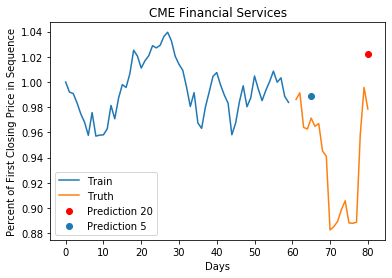

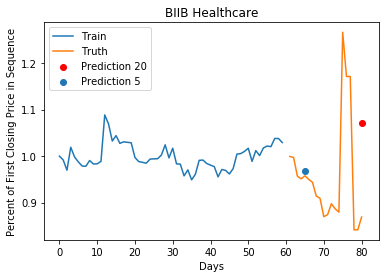

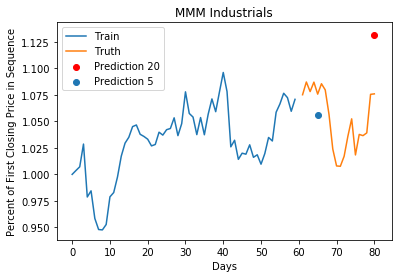

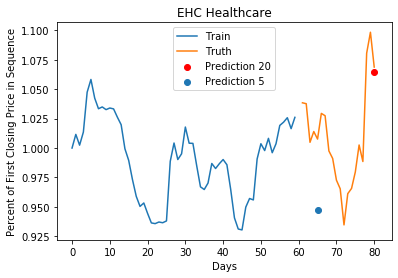

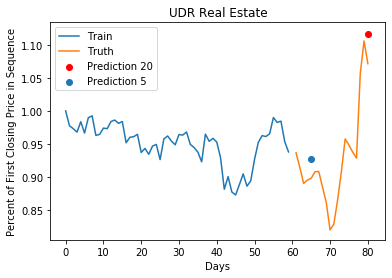

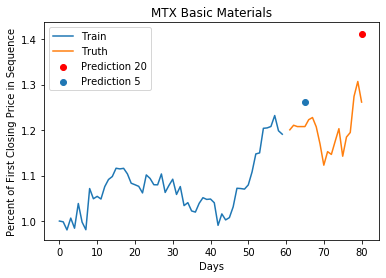

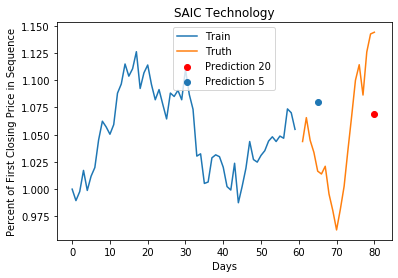

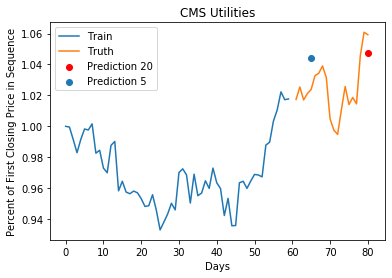

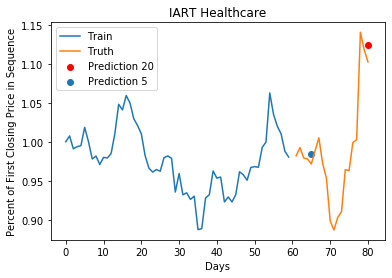

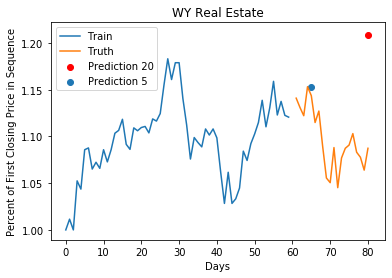

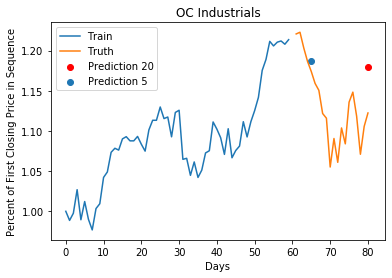

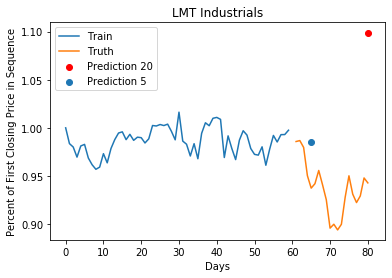

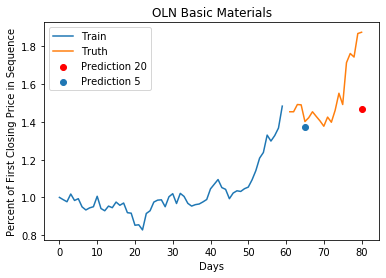

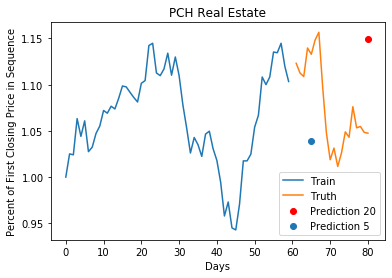

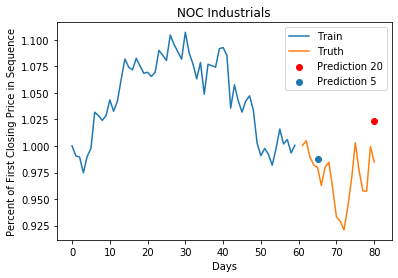

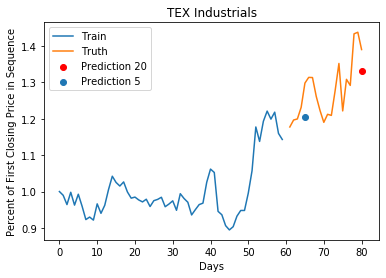

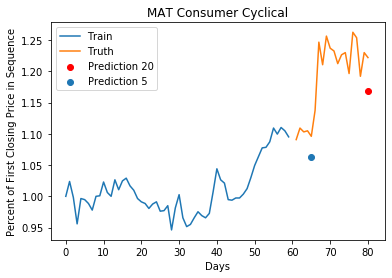

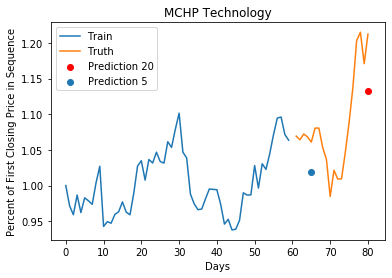

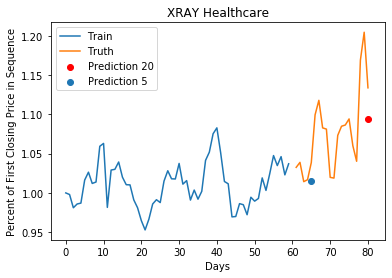

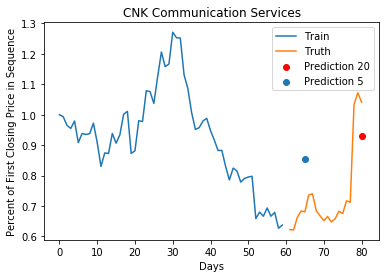

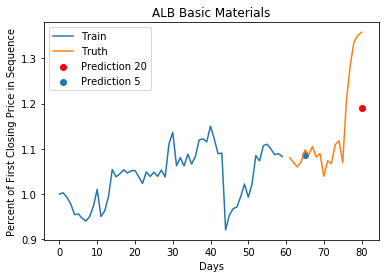

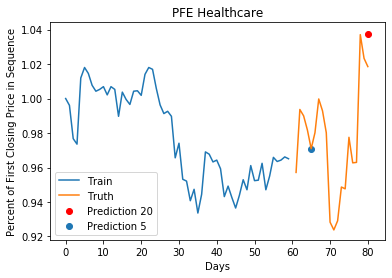

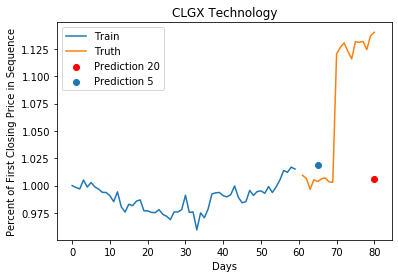

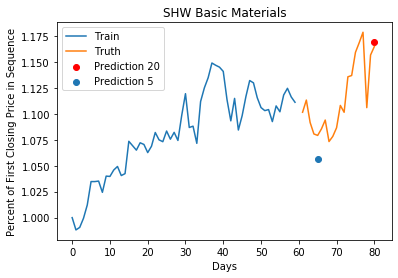

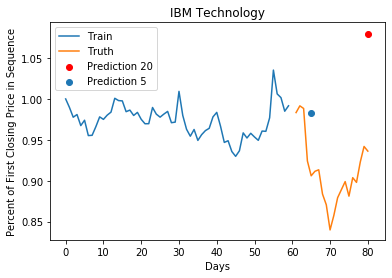

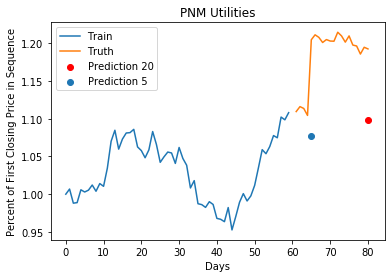

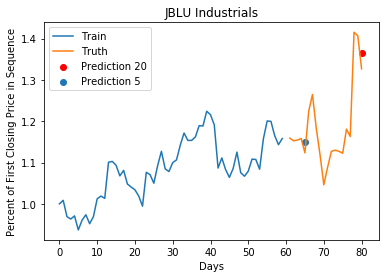

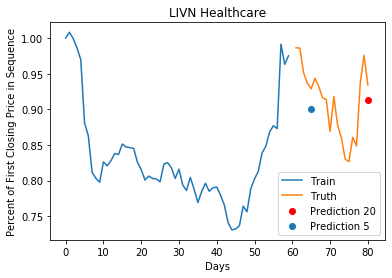

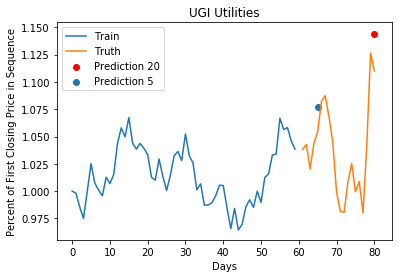

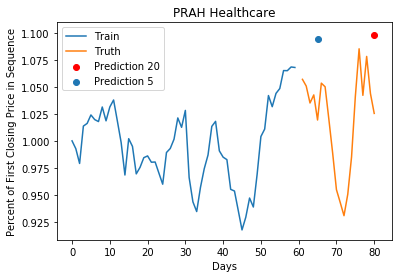

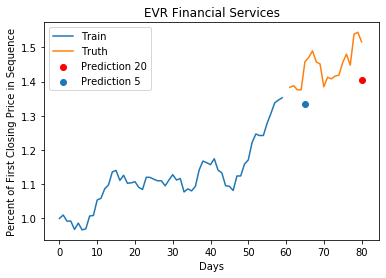

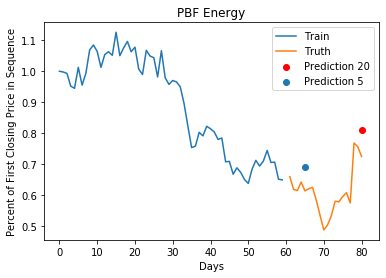

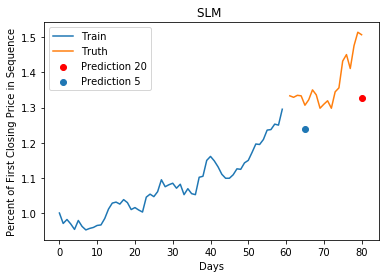

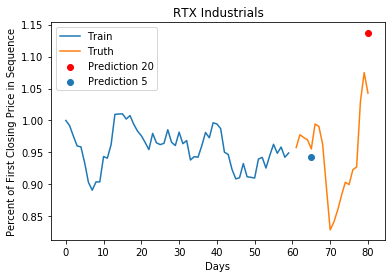

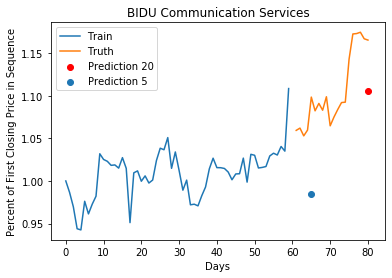

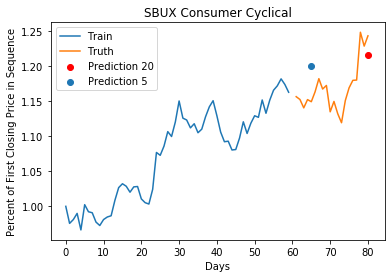

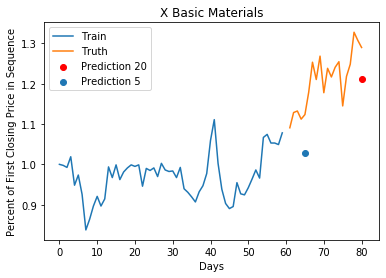

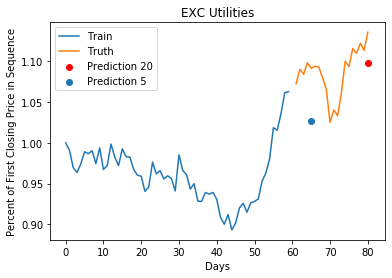

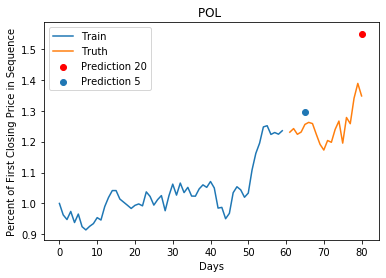

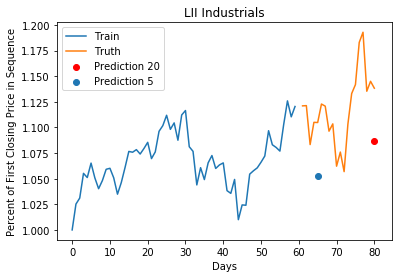

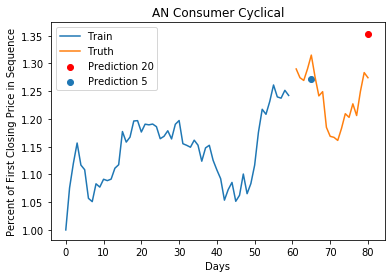

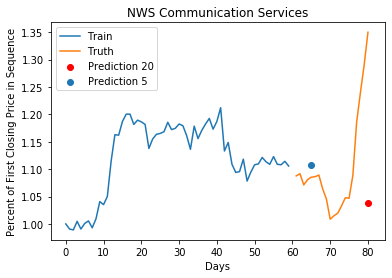

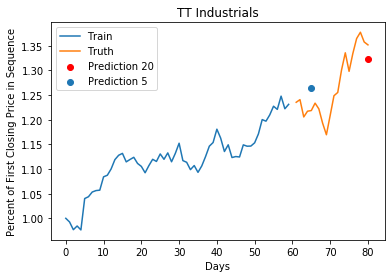

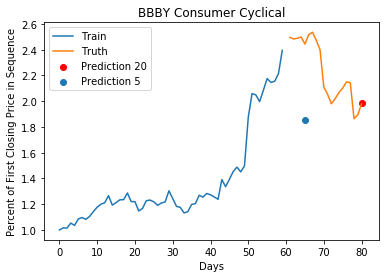

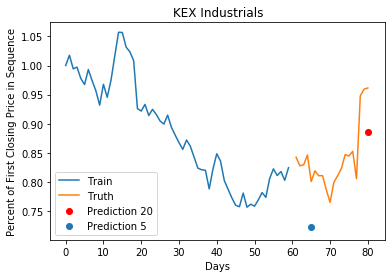

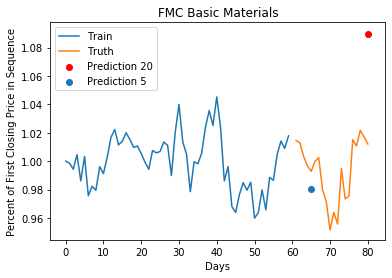

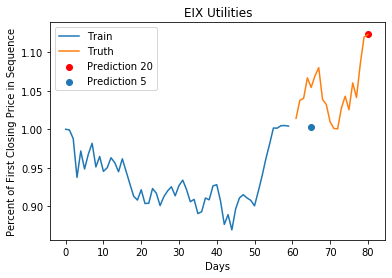

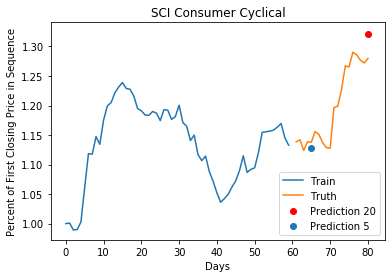

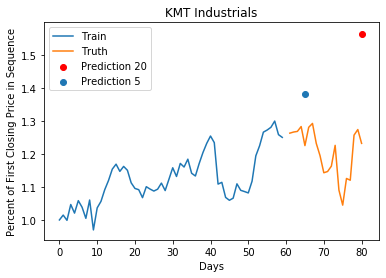

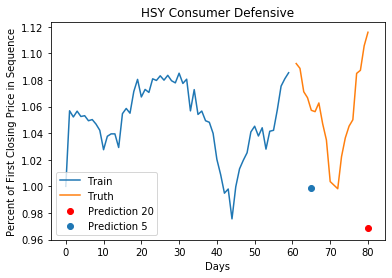

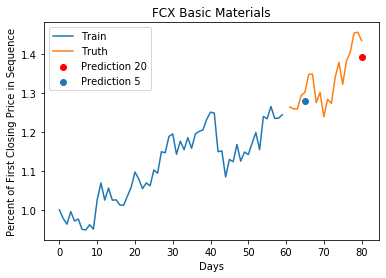

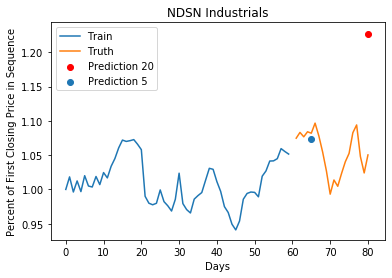

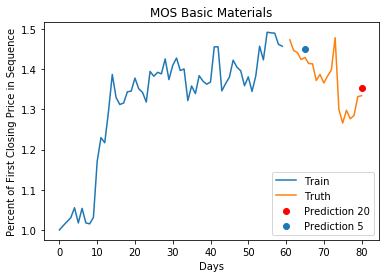

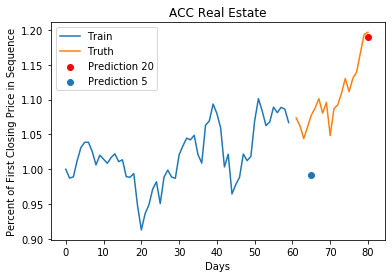

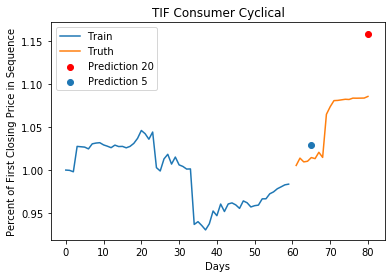

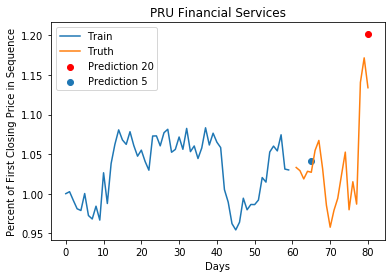

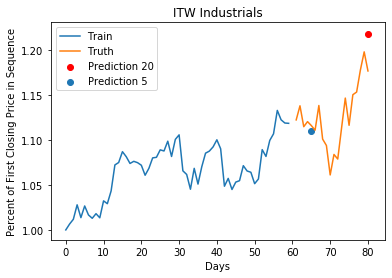

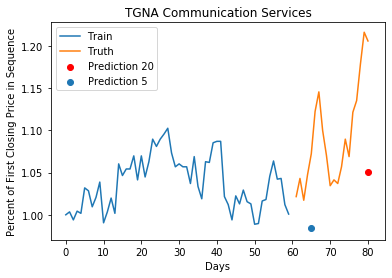

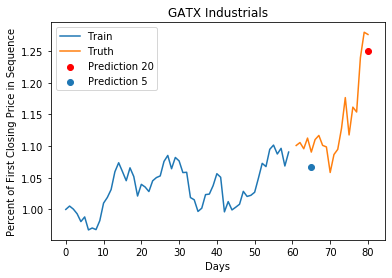

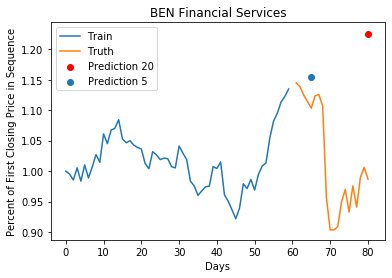

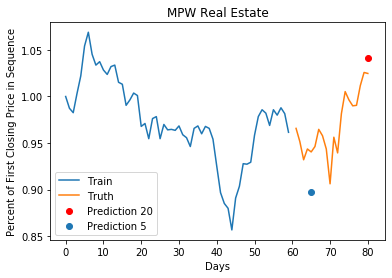

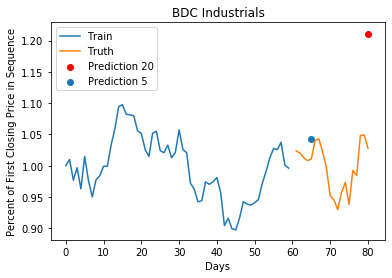

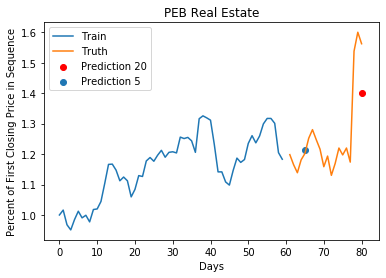

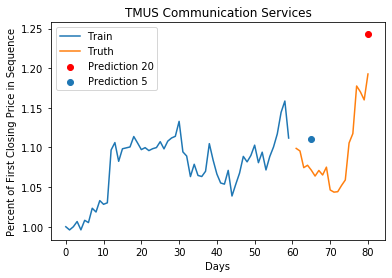

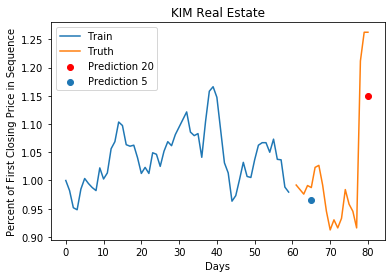

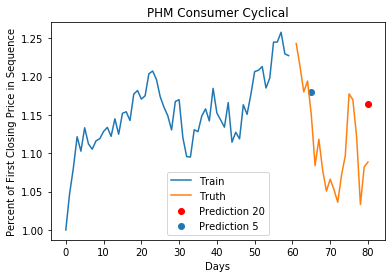

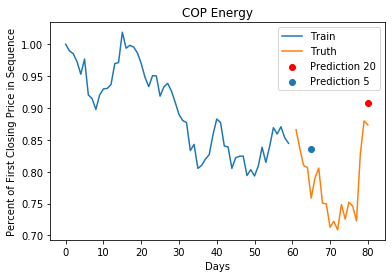

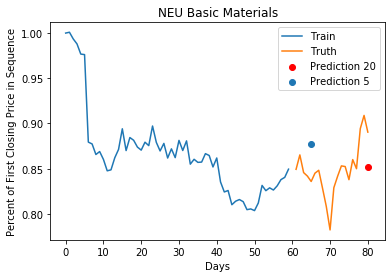

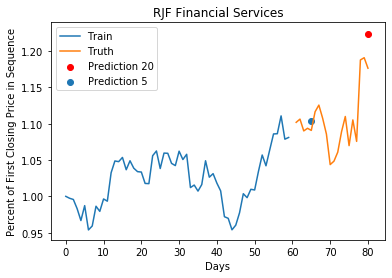

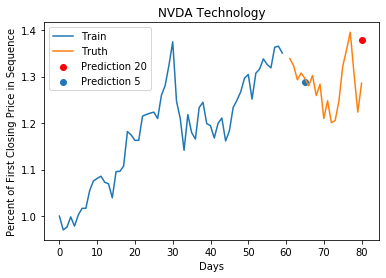

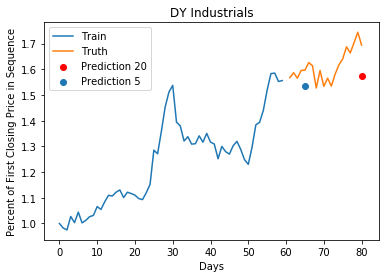

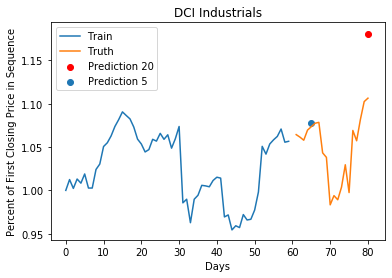

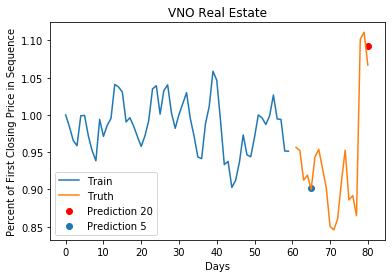

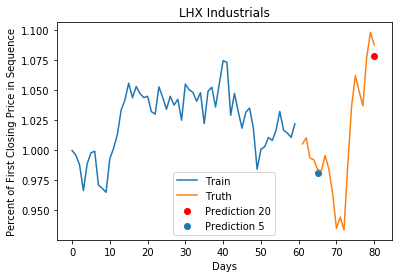

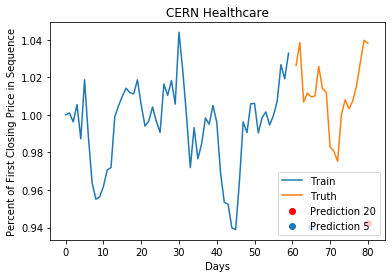

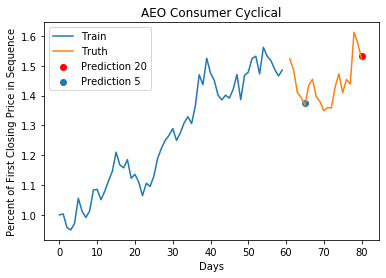

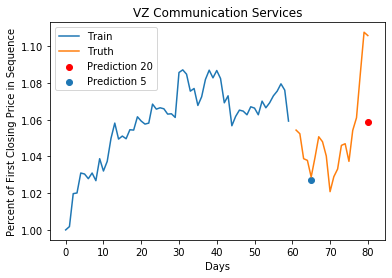

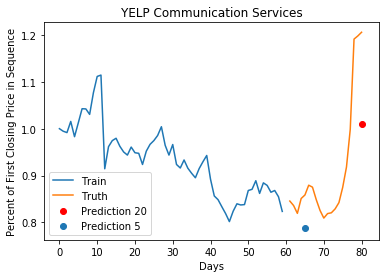

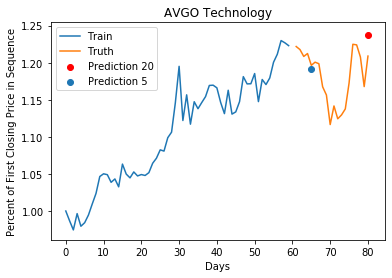

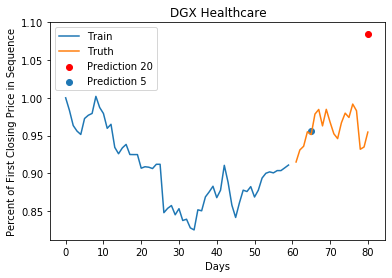

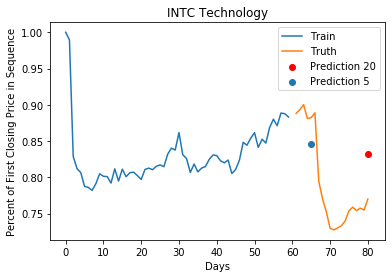

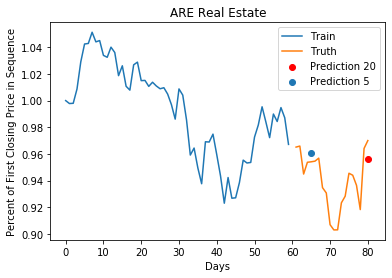

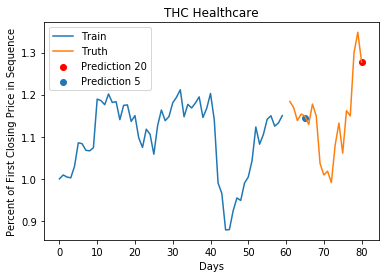

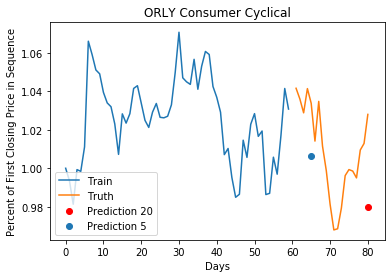

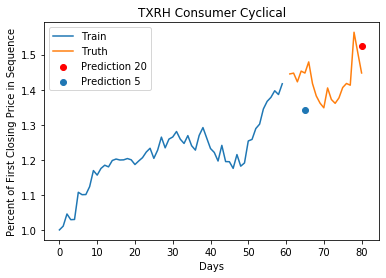

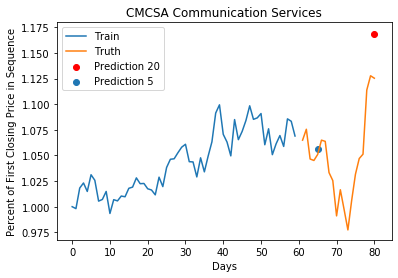

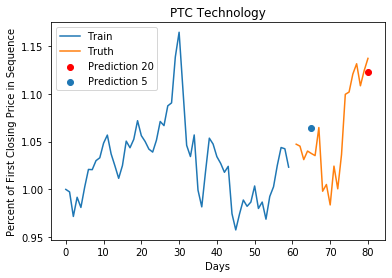

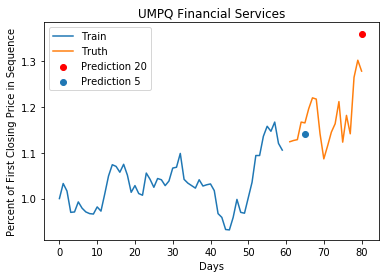

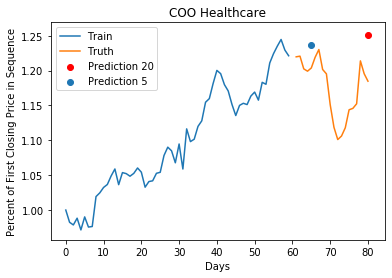

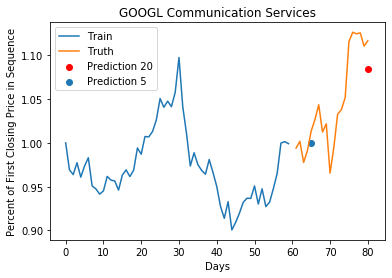

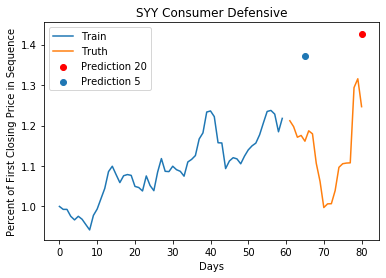

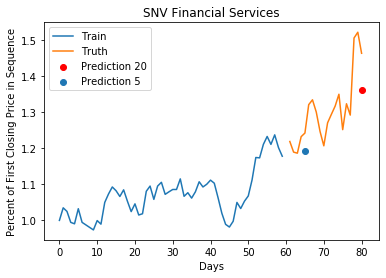

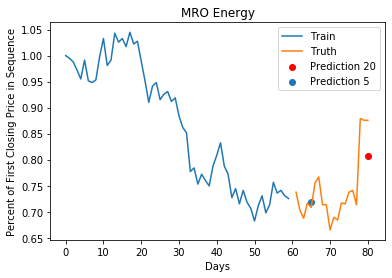

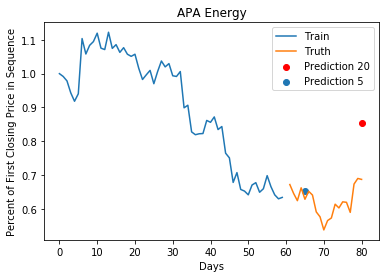

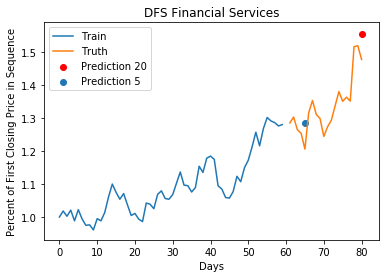

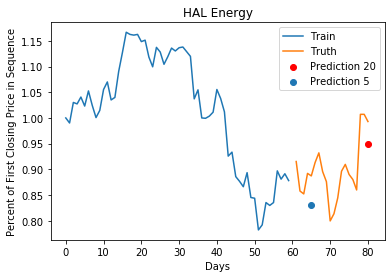

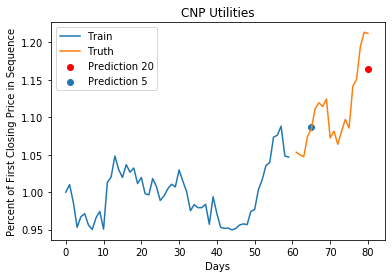

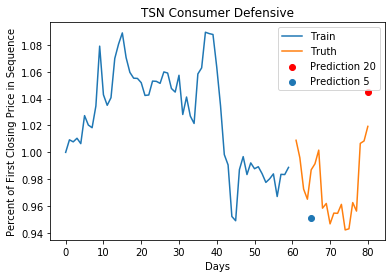

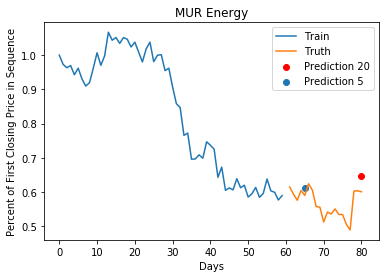

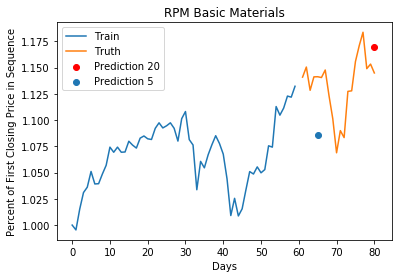

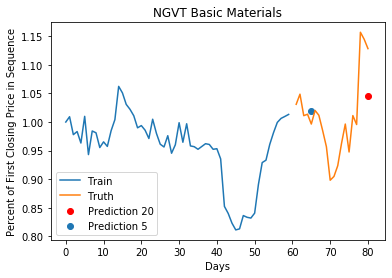

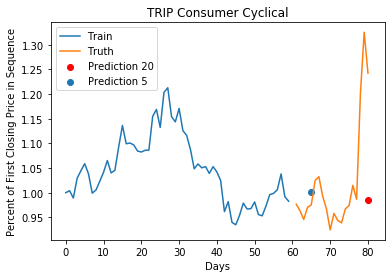

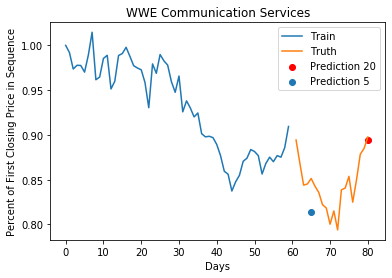

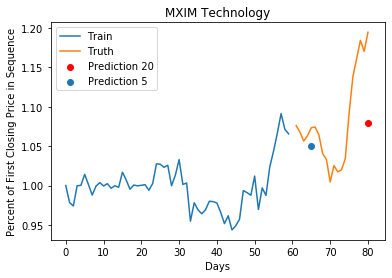

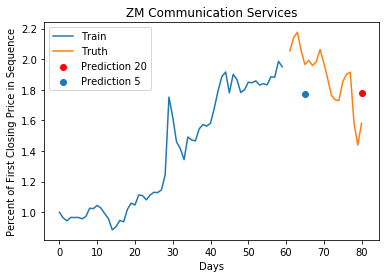

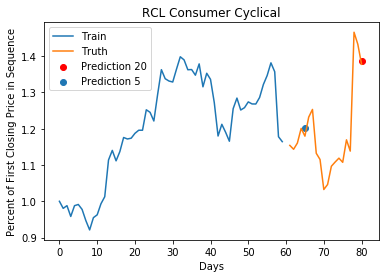

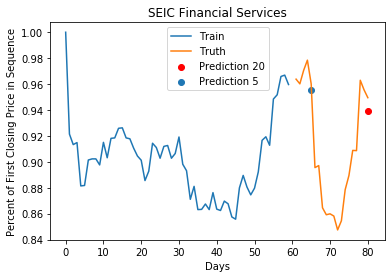

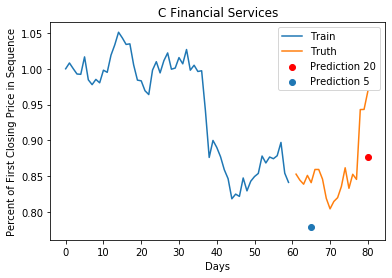

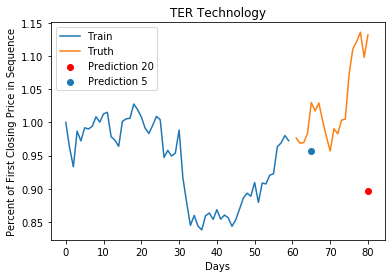

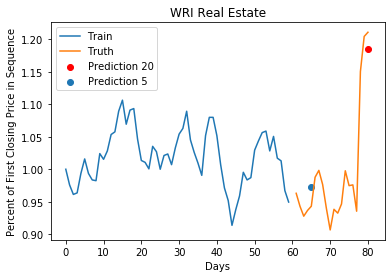

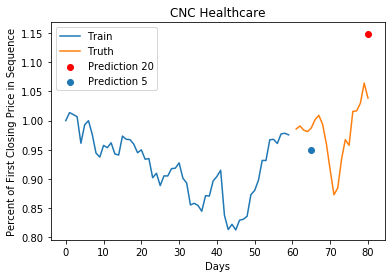

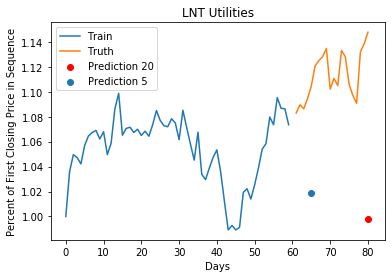

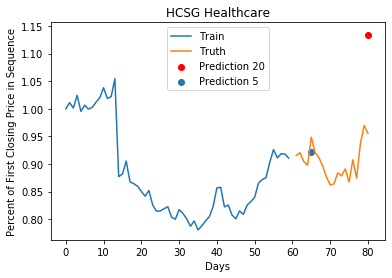

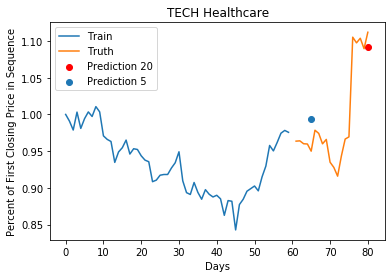

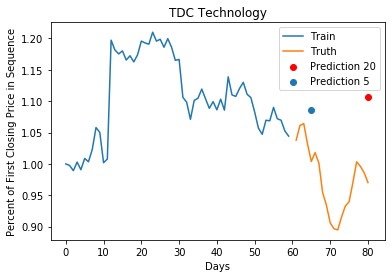

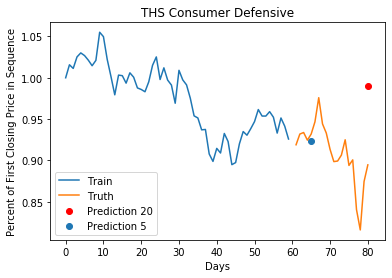

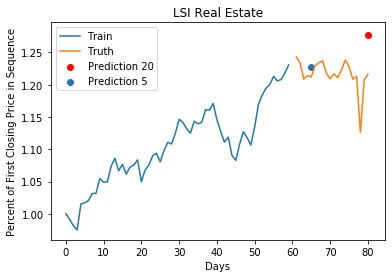

In [7]:
length = 60
cast = 20
seqtype = "Short"
checkpath = r'C:\Users\conno\Documents\Stocks\checkpoints\Final\checkpoints'

X_path = r'C:\Users\conno\Documents\Stocks\X_test_model' + str(length)+str(cast)+".npy"
y_path = r'C:\Users\conno\Documents\Stocks\y_test_model' + str(length)+str(cast)+".npy"
X_test = np.load(X_path,allow_pickle = True)
y_test = np.load(y_path,allow_pickle = True)
X_test=np.asarray(X_test).astype(np.float32)
y_test=np.asarray(y_test).astype(np.float32)

regressor = Sequential()
regressor.add(LSTM(units=450, return_sequences=True, input_shape=(length, 8)))
regressor.add(LSTM(units=350, return_sequences=True))
regressor.add(LSTM(units=250, return_sequences=True))
regressor.add(LSTM(units=150, return_sequences=True))
regressor.add(LSTM(units=50))
regressor.add(Dense(units=cast))

regressor.load_weights(checkpath)
preds = regressor.predict(X_test)
predictions = pd.DataFrame(preds,columns = ['Pred1','Pred2','Pred3','Pred4','Pred5','Pred6','Pred7','Pred8','Pred9','Pred10','Pred11','Pred12','Pred13','Pred14','Pred15','Pred16','Pred17','Pred18','Pred19','Pred20'])
Truth = pd.DataFrame(y_test,columns = ['Truth1','Truth2','Truth3','Truth4','Truth5','Truth6','Truth7','Truth8','Truth9','Truth10','Truth11','Truth12','Truth13','Truth14','Truth15','Truth16','Truth17','Truth18','Truth19','Truth20'])
Sector = pd.DataFrame(sectorlist,columns=['Sector'])
Tick = pd.DataFrame(testticklist,columns=['Ticker'])
pd.set_option('display.float_format', lambda x: '%.3f' % x)
TwentyTwentyShort = predictions.join(Truth, how='left')
TwentyTwentyShort = TwentyTwentyShort.join(Tick,how='left')
TwentyTwentyShort = TwentyTwentyShort.join(Sector,how='left')

MSE = mean_squared_error(predictions['Pred20'],Truth['Truth20'],squared = False)
MAE = mean_absolute_error(predictions['Pred20'],Truth['Truth20'])
print(MSE)
print(MAE)
for i in range(0,len(TwentyTwentyShort)):
    plt.plot(np.arange(60),X_test[i,:,1:2])
    plt.scatter(80,TwentyTwentyShort.loc[i,'Pred20'],color = 'r')
    plt.scatter(65,TwentyTwentyShort.loc[i,'Pred5'])
    plt.plot(np.linspace(61,80,20),TwentyTwentyShort.loc[i,'Truth1':'Truth20'])
    plt.title(str(TwentyTwentyShort.loc[i,'Ticker'])+" "+str(TwentyTwentyShort.loc[i,'Sector']))
    plt.xlabel('Days')
    plt.ylabel('Percent of First Closing Price in Sequence')
    plt.legend(['Train','Truth','Prediction 20','Prediction 5'])
    plt.show()
    i = i + 1

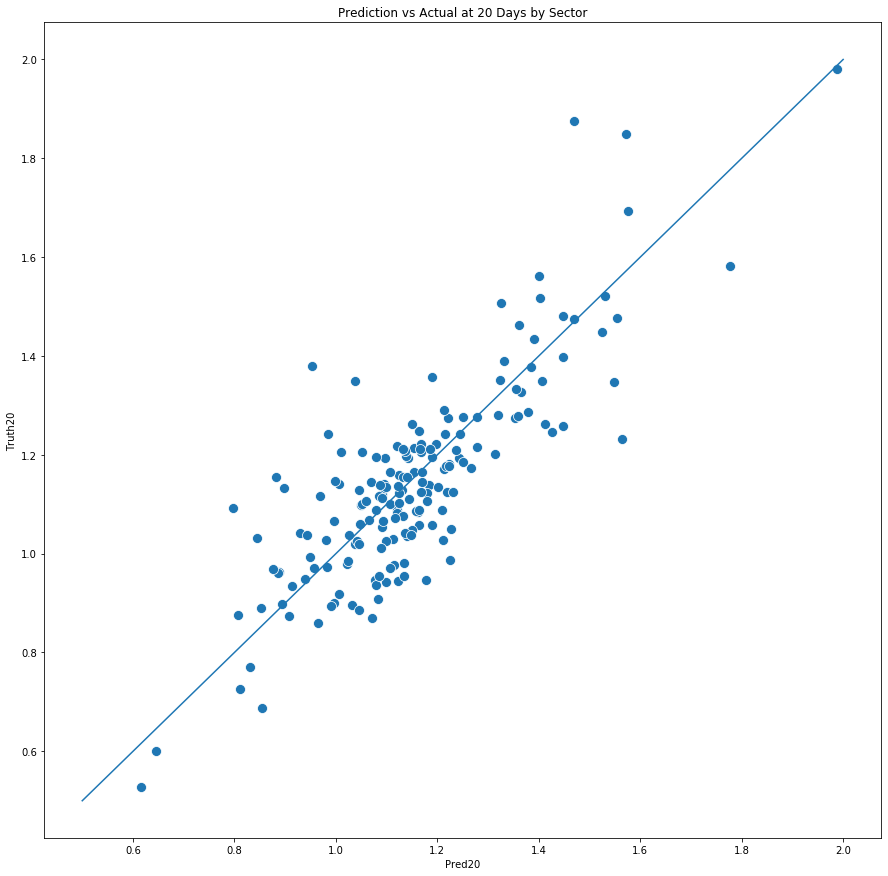

In [11]:
plt.figure(figsize=(15,15))
import seaborn as sns
sns.scatterplot('Pred20', 'Truth20', data=TwentyTwentyShort, s= 100)
plt.plot(np.linspace(.5,2,5),np.linspace(.5,2,5))
plt.title('Prediction vs Actual at 20 Days by Sector')
plt.show()

In [2]:
#creats data frame of training data used to create sequences
stock = 'TXN'
window = 60
sequence = 20
momentumlag = 90
momentum90= []
momentum_price90 = []
minmax = pd.DataFrame(columns=['ticker','minopen','maxopen','minclose','maxclose','minlow','maxlow','minhigh','maxhigh','minvolume','maxvolume'])
alldataonetest = pd.DataFrame(columns=['Date','ticker','Open','High','Low','Close','Volume','RSI','momentum','momentum_price'])
history = yf.Ticker(stock).history(start="2010-01-01").reset_index()
history = history[history['Date']<="2020-11-11"].copy()
history = history.dropna()
if len(history) >= momentumlag+1:
        oneofftest = history.loc[:len(history)-sequence-1].copy()
        minmax = minmax.append({'ticker':stock,'minopen':min(oneofftest['Open']),'maxopen':max(oneofftest['Open']),'minclose':min(oneofftest['Close']),'maxclose':max(oneofftest['Close']),
                                'minlow':min(oneofftest['Low']),'maxlow':max(oneofftest['Low']),'minhigh':max(oneofftest['Low']),'maxhigh':min(oneofftest['High']),
                                'minvolume':min(oneofftest['Volume']),'maxvolume':max(oneofftest['Volume'])},ignore_index = True)
        oneofftest['PrevClose'] = oneofftest['Close'].shift(1)
        oneofftest['1DayChange'] = oneofftest['Close'] - oneofftest['PrevClose']
        oneofftest.loc[oneofftest['1DayChange'] > 0, 'Up'] = oneofftest['1DayChange'] 
        oneofftest.loc[oneofftest['1DayChange'] < 0, 'Up'] = 0
        oneofftest.loc[oneofftest['1DayChange'] < 0, 'Down'] = oneofftest['1DayChange']
        oneofftest.loc[oneofftest['1DayChange'] > 0, 'Down'] = 0
        oneofftest['RollUp'] = oneofftest['Up'].rolling(14,min_periods=0).mean()
        oneofftest['RollDown'] = oneofftest['Down'].rolling(14,min_periods=0).mean().abs()
        oneofftest['RSI'] = round(100 - (100/(1+(oneofftest['RollUp']/oneofftest['RollDown']))),4)
        oneofftest['RSI'] = np.nan_to_num(oneofftest['RSI'])
        momentum = []
        momentum_price = []
        for i in range(momentumlag-1,len(oneofftest)-1):
                rets = np.log(oneofftest['Close'].iloc[i-momentumlag+1:i+1])
                x = np.arange(len(rets))
                slope, intercept, r_value, p_value, std_err = linregress(x, rets)
                momentum.append(round(((1 + slope) ** 252) * (r_value ** 2),4))
                momentum_price.append(round(np.e ** (intercept + slope*len(x)),4))
        oneofftest['momentum'] = np.append(np.linspace(np.nan,np.nan,momentumlag),momentum)
        oneofftest['momentum_price'] = np.append(np.linspace(np.nan,np.nan,momentumlag),momentum_price)
        oneofftest['ticker'] = stock
        oneofftest = oneofftest[['Date','ticker','Open','High','Low','Close','Volume','RSI','momentum','momentum_price']].iloc[momentumlag:].copy()
        alldataonetest = alldataonetest.append(oneofftest)
        
tickersym = stock
ticker = stock
ticklist = []
X_testone = []
y_testone = []
ticker = alldataonetest[['Date','ticker','Open','High','Low','Close','Volume','RSI','momentum','momentum_price']][alldataonetest['ticker']==ticker].reset_index(drop = True)
ticker['Volume'] = ticker['Volume'].replace(0,1)
prevclose = ticker['Close'].iloc[len(ticker)-window]
prevopen  = ticker['Open'].iloc[len(ticker)-window]
prevhigh  = ticker['High'].iloc[len(ticker)-window]
prevlow   = ticker['Low'].iloc[len(ticker)-window]
prevvol   = ticker['Volume'].iloc[len(ticker)-window]

normclose = ticker['Close'].iloc[len(ticker)-window:] / prevclose
normopen = ticker['Open'].iloc[len(ticker)-window:] / prevopen
normhigh = ticker['High'].iloc[len(ticker)-window:] / prevhigh
normlow = ticker['Low'].iloc[len(ticker)-window:] / prevlow
normvol = ticker[['Volume']].iloc[len(ticker)-window:] / prevvol
normmomentum = ticker['momentum'].iloc[len(ticker)-window:] 
normmomentumprice = ticker['momentum_price'].iloc[len(ticker)-window:] / prevclose
normrsi = ticker['RSI'].iloc[len(ticker)-window:] / 100
X_append =  np.hstack((np.reshape(normopen.values,(-1,1)),
        np.reshape(normclose.values,(-1,1)),
        np.reshape(normlow.values,(-1,1)),
        np.reshape(normhigh.values,(-1,1)),
        np.reshape(normvol.values,(-1,1)),
        np.reshape(normmomentum.values,(-1,1)),
        np.reshape(normmomentumprice.values,(-1,1)),
        np.reshape(normrsi.values,(-1,1))))
if pd.isnull(X_append).any() or len(X_append) != window:
    X_testone = ""
else:
    X_testone.append(X_append)
    testset = yf.Ticker(tickersym).history(start="2020-01-01").reset_index()
    testset = testset[testset['Date']<="2020-11-11"]
    y_testone.append(testset['Close'].iloc[len(testset)-sequence:].values / prevclose)
    ticklist.append(tickersym)
    
X_testone=np.asarray(X_testone).astype(np.float32)
y_testone=np.asarray(y_testone).astype(np.float32)

preds = regressor.predict(X_testone)

plt.plot(np.linspace(1,60,60),X_testone[0,:,1])
plt.plot(np.linspace(61,80,20),preds[0])
plt.plot(np.linspace(61,80,20),y_testone[0])

NameError: name 'regressor' is not defined

In [14]:
testticklist

array(['NYT', 'CONE', 'FBHS', 'HUBB', 'TPX', 'SABR', 'FFIV', 'COST',
       'FLR', 'COHR', 'CVS', 'SNPS', 'HAE', 'ROST', 'FDS', 'DVN', 'NRG',
       'AM', 'TXN', 'PDD', 'EQR', 'CTSH', 'REG', 'AOS', 'TJX', 'SIVB',
       'ZBH', 'FCN', 'PB', 'CC', 'PACW', 'TKR', 'UHS', 'JBL', 'ABC',
       'ITT', 'WAFD', 'FTI', 'HQY', 'BR', 'OMC', 'GL', 'GPN', 'COG',
       'MTB', 'TECD', 'WTFC', 'PGR', 'MSA', 'AGCO', 'ATO', 'ODFL', 'VSAT',
       'DOV', 'JNPR', 'TEL', 'TPR', 'MKTX', 'KR', 'AVY', 'RIG', 'CME',
       'BIIB', 'MMM', 'EHC', 'UDR', 'MTX', 'SAIC', 'CMS', 'IART', 'WY',
       'OC', 'LMT', 'OLN', 'PCH', 'NOC', 'TEX', 'MAT', 'MCHP', 'XRAY',
       'CNK', 'ALB', 'PFE', 'CLGX', 'SHW', 'IBM', 'PNM', 'JBLU', 'LIVN',
       'UGI', 'PRAH', 'EVR', 'PBF', 'SLM', 'RTX', 'BIDU', 'SBUX', 'X',
       'EXC', 'POL', 'LII', 'AN', 'NWS', 'TT', 'BBBY', 'KEX', 'FMC',
       'EIX', 'SCI', 'KMT', 'HSY', 'FCX', 'NDSN', 'MOS', 'ACC', 'TIF',
       'PRU', 'ITW', 'TGNA', 'GATX', 'BEN', 'MPW', 'BDC', 'PEB', 'TMUS',
   